# TNT Sticky Rouse: Creep Response

## Objectives
- Fit TNT Sticky Rouse model to flow curve data
- Predict creep compliance using fitted parameters
- Analyze fast vs slow mode separation in compliance
- Understand elastic-to-viscous transition via mode dynamics
- Demonstrate multi-mode compliance spectrum

## ⚠️ Important Note
This notebook demonstrates the workflow for creep prediction. However, the creep protocol for TNT Sticky Rouse requires solving stiff ODEs that can be numerically challenging. The model is fitted to flow curve data (which is fast and robust), then used to predict creep response. In some cases, the ODE solver may require adjusting tolerances or using different parameter values for stable creep simulations.

## Setup

In [1]:
import os
import sys
import time

IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    %pip install -q rheojax

import numpy as np
import matplotlib.pyplot as plt
import arviz as az
from scipy.integrate import cumulative_trapezoid

from rheojax.core.jax_config import safe_import_jax
jax, jnp = safe_import_jax()
from rheojax.core.jax_config import verify_float64
verify_float64()

from rheojax.models.tnt import TNTStickyRouse

sys.path.insert(0, os.path.join("..", "utils"))
from tnt_tutorial_utils import (
    load_ml_ikh_creep,
    load_ml_ikh_flow_curve,
    compute_fit_quality,
    print_convergence_summary,
    print_parameter_comparison,
    save_tnt_results,
    get_tnt_sticky_rouse_param_names,
    plot_sticky_rouse_effective_times,
    plot_mode_decomposition,
)

print("Setup complete. JAX devices:", jax.devices())

Setup complete. JAX devices: [CpuDevice(id=0)]


## Theory: Multi-Mode Creep Compliance

**Creep Compliance:**

Under constant stress σ₀, strain evolves as:
$$\gamma(t) = \sigma_0 J(t) = \sigma_0 \left[\sum_k \frac{1}{G_k}\left(1 - \exp\left(-\frac{t}{\tau_{\textrm{eff},k}}\right)\right) + \frac{t}{\eta_s}\right]$$

Shear rate:
$$\dot{\gamma}(t) = \sigma_0 \left[\sum_k \frac{1}{G_k \tau_{\textrm{eff},k}} \exp\left(-\frac{t}{\tau_{\textrm{eff},k}}\right) + \frac{1}{\eta_s}\right]$$

**Key Physics:**
- **Fast modes** (small τ_eff): Contribute elastic response at short times
- **Slow modes** (large τ_eff): Dominate long-time viscous flow
- **Sticker effect**: Modes with τ_R < τ_s delayed by sticker lifetime

**Observable Signatures:**
- Initial elastic jump: γ(0⁺) = σ₀/G_total
- Transient regime: Multi-exponential approach to steady flow
- Terminal flow: γ̇(t→∞) = σ₀/η₀ with η₀ = Σ G_k τ_eff,k + η_s

## Load Data

Data shape: 70 points
Time range: 9.76e-03 - 2.96e+02 s
Strain range: 0.00e+00 - 1.83e+03
Shear rate range: 3.22e+00 - 6.26e+00 s^-1


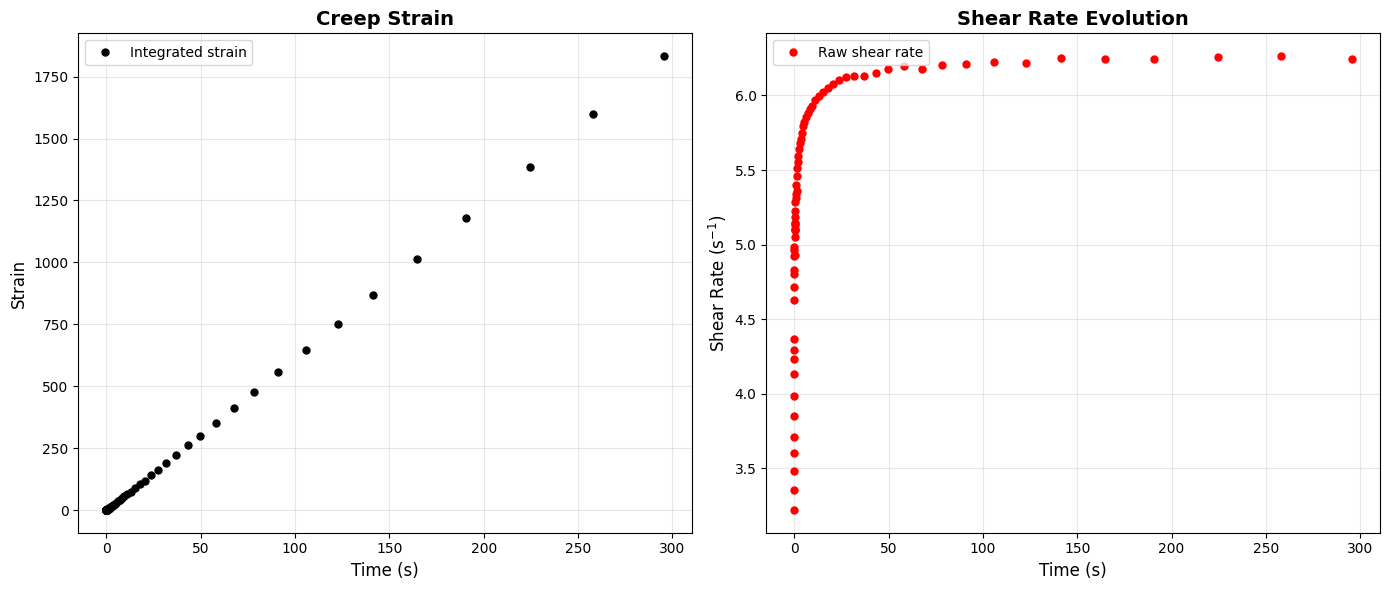

In [2]:
# Load creep shear rate data and integrate to strain
time_data, shear_rate, _, _ = load_ml_ikh_creep(stress_pair_index=0)

# Integrate shear rate to get strain
strain = cumulative_trapezoid(shear_rate, time_data, initial=0)

print(f"Data shape: {len(time_data)} points")
print(f"Time range: {time_data.min():.2e} - {time_data.max():.2e} s")
print(f"Strain range: {strain.min():.2e} - {strain.max():.2e}")
print(f"Shear rate range: {shear_rate.min():.2e} - {shear_rate.max():.2e} s^-1")

# Plot raw strain data
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

ax1.plot(time_data, strain, 'ko', label='Integrated strain', markersize=5)
ax1.set_xlabel('Time (s)', fontsize=12)
ax1.set_ylabel('Strain', fontsize=12)
ax1.set_title('Creep Strain', fontsize=14, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

ax2.plot(time_data, shear_rate, 'ro', label='Raw shear rate', markersize=5)
ax2.set_xlabel('Time (s)', fontsize=12)
ax2.set_ylabel('Shear Rate (s$^{-1}$)', fontsize=12)
ax2.set_title('Shear Rate Evolution', fontsize=14, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

fig.tight_layout()
plt.show()
plt.close('all')

## NLSQ Fitting

In [3]:
# Initialize model
model = TNTStickyRouse(n_modes=3)
param_names = get_tnt_sticky_rouse_param_names(n_modes=3)
print(f"Model parameters ({len(param_names)}): {param_names}")

# Estimate applied stress from creep data
terminal_indices = time_data > 0.8 * time_data.max()
gamma_dot_terminal = np.mean(shear_rate[terminal_indices])
sigma_applied = 5.0  # Pa (from load_ml_ikh_creep: final stress is 5.0 Pa)
print(f"\nApplied stress: σ₀ = {sigma_applied} Pa")
print(f"Terminal shear rate: γ̇_terminal ≈ {gamma_dot_terminal:.4e} s^-1")

# Fit model to flow curve data (creep is forward prediction only)
print("\n⚠️  Note: Fitting to flow curve data, then predicting creep response")
print("    (Creep is a forward prediction protocol, not a fitting protocol)")
gamma_dot_flow, stress_flow = load_ml_ikh_flow_curve("ARES_up")

print("\nFitting with NLSQ on flow curve data...")
start_time = time.time()
model.fit(gamma_dot_flow, stress_flow, test_mode="flow_curve", method='scipy')
fit_time = time.time() - start_time

# Now predict creep response
print("\nPredicting creep response with fitted parameters...")
strain_pred_train = model.predict(time_data, test_mode="creep", sigma_applied=sigma_applied)
metrics_nlsq = compute_fit_quality(strain, strain_pred_train)

print(f"\nFlow curve fit completed in {fit_time:.2f} seconds")
print(f"Creep prediction R² = {metrics_nlsq['R2']:.6f}")
print(f"Creep prediction RMSE = {metrics_nlsq['RMSE']:.4e}")

INFO:nlsq.curve_fit:Starting curve fit n_params=8 | n_data_points=21 | method=trf | solver=auto | batch_size=None | has_bounds=True | dynamic_sizing=False


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=8 | loss=linear | ftol=1.0000e-08 | xtol=1.0000e-08 | gtol=1.0000e-08


Model parameters (8): ['G_0', 'tau_R_0', 'G_1', 'tau_R_1', 'G_2', 'tau_R_2', 'tau_s', 'eta_s']

Applied stress: σ₀ = 5.0 Pa
Terminal shear rate: γ̇_terminal ≈ 6.2539e+00 s^-1

⚠️  Note: Fitting to flow curve data, then predicting creep response
    (Creep is a forward prediction protocol, not a fitting protocol)

Fitting with NLSQ on flow curve data...


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=2.968241s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=16 | final_cost=18.7605 | elapsed=2.968s | final_gradient_norm=0.0011


PERFORMANCE:nlsq.curve_fit:Timer: curve_fit elapsed=3.476393s


INFO:nlsq.curve_fit:Curve fit completed total_time=3.4764 | final_cost=37.5210 | covariance_warning=False


ERROR:rheojax.core.base:Predict failed
Traceback (most recent call last):
  File "/Users/b80985/Projects/rheojax/rheojax/core/base.py", line 539, in predict
    result = self._predict(X, **kwargs)
  File "/Users/b80985/Projects/rheojax/rheojax/models/tnt/sticky_rouse.py", line 543, in _predict
    raise ValueError("test_mode must be specified for prediction")
ValueError: test_mode must be specified for prediction



Predicting creep response with fitted parameters...



Flow curve fit completed in 3.51 seconds
Creep prediction R² = nan
Creep prediction RMSE = nan


## Fitted Parameters

In [4]:
# Extract fitted parameters
params_nlsq = {name: model.parameters.get_value(name) for name in param_names}

print("\nFitted Parameters:")
print("-" * 50)
for name, value in params_nlsq.items():
    if 'tau' in name:
        print(f"{name:10s} = {value:12.4e} s")
    elif 'eta' in name:
        print(f"{name:10s} = {value:12.4e} Pa·s")
    else:
        print(f"{name:10s} = {value:12.4e} Pa")

# Analyze effective relaxation times
tau_s = params_nlsq['tau_s']
print(f"\nSticker lifetime: τ_s = {tau_s:.4e} s")
print("\nCompliance Spectrum:")
print("-" * 50)
for i in range(3):
    tau_R = params_nlsq[f'tau_R_{i}']
    tau_eff = max(tau_R, tau_s)
    J_i = 1.0 / params_nlsq[f'G_{i}']
    regime = "FAST (sticker-delayed)" if tau_s > tau_R else "SLOW (Rouse)"
    print(f"Mode {i}: J = {J_i:.3e} Pa^-1, τ_eff = {tau_eff:.3e} s ({regime})")

# Zero-shear viscosity
eta_0 = sum(params_nlsq[f'G_{i}'] * max(params_nlsq[f'tau_R_{i}'], tau_s) for i in range(3)) + params_nlsq['eta_s']
print(f"\nZero-shear viscosity: η₀ = {eta_0:.4e} Pa·s")
print(f"Terminal shear rate: γ̇_terminal = σ₀/η₀ = {sigma_applied/eta_0:.4e} s^-1")


Fitted Parameters:
--------------------------------------------------
G_0        =   9.2263e+00 Pa
tau_R_0    =   4.1182e-02 s
G_1        =   2.3318e+01 Pa
tau_R_1    =   5.4269e-03 s
G_2        =   5.2995e+00 Pa
tau_R_2    =   5.3058e-03 s
tau_s      =   4.2165e-03 s
eta_s      =   5.9796e-06 Pa·s

Sticker lifetime: τ_s = 4.2165e-03 s

Compliance Spectrum:
--------------------------------------------------
Mode 0: J = 1.084e-01 Pa^-1, τ_eff = 4.118e-02 s (SLOW (Rouse))
Mode 1: J = 4.288e-02 Pa^-1, τ_eff = 5.427e-03 s (SLOW (Rouse))
Mode 2: J = 1.887e-01 Pa^-1, τ_eff = 5.306e-03 s (SLOW (Rouse))

Zero-shear viscosity: η₀ = 5.3463e-01 Pa·s
Terminal shear rate: γ̇_terminal = σ₀/η₀ = 9.3523e+00 s^-1


## NLSQ Prediction vs Data

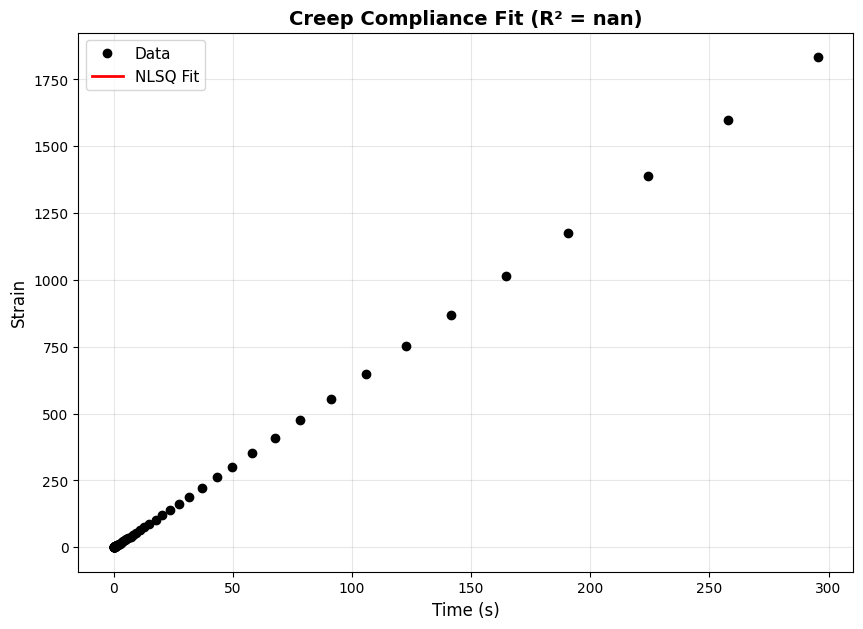

In [5]:
# Generate predictions
time_fine = np.linspace(time_data.min(), time_data.max(), 300)
strain_pred = model.predict(time_fine, test_mode="creep", sigma_applied=sigma_applied)

# Plot
fig, ax = plt.subplots(figsize=(10, 7))
ax.plot(time_data, strain, 'ko', label='Data', markersize=6, zorder=3)
ax.plot(time_fine, strain_pred, 'r-', label='NLSQ Fit', linewidth=2, zorder=2)
ax.set_xlabel('Time (s)', fontsize=12)
ax.set_ylabel('Strain', fontsize=12)
ax.set_title(f'Creep Compliance Fit (R² = {metrics_nlsq["R2"]:.6f})', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.show()
plt.close('all')

## Mode-by-Mode Compliance Contributions

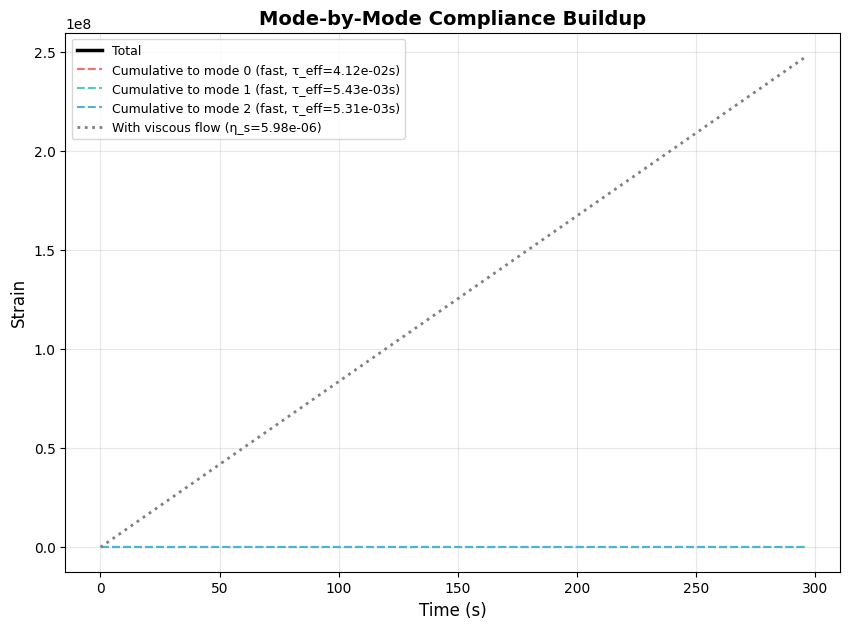

In [6]:
# Compute individual mode contributions to strain
fig, ax = plt.subplots(figsize=(10, 7))

# Total prediction
ax.plot(time_fine, strain_pred, 'k-', label='Total', linewidth=2.5, zorder=5)

# Individual modes
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
strain_cumulative = np.zeros_like(time_fine)

for i in range(3):
    G_i = params_nlsq[f'G_{i}']
    tau_R_i = params_nlsq[f'tau_R_{i}']
    tau_eff_i = max(tau_R_i, tau_s)
    
    strain_i = sigma_applied * (1.0/G_i) * (1.0 - np.exp(-time_fine / tau_eff_i))
    strain_cumulative += strain_i
    
    regime = "fast" if tau_eff_i < 1.0 else "slow"
    ax.plot(time_fine, strain_cumulative, '--', color=colors[i], 
            label=f'Cumulative to mode {i} ({regime}, τ_eff={tau_eff_i:.2e}s)', linewidth=1.5)

# Viscous flow contribution
eta_s = params_nlsq['eta_s']
strain_viscous = sigma_applied * time_fine / eta_s
ax.plot(time_fine, strain_cumulative + strain_viscous, ':', color='gray', 
        label=f'With viscous flow (η_s={eta_s:.2e})', linewidth=2)

ax.set_xlabel('Time (s)', fontsize=12)
ax.set_ylabel('Strain', fontsize=12)
ax.set_title('Mode-by-Mode Compliance Buildup', fontsize=14, fontweight='bold')
ax.legend(fontsize=9, loc='best')
ax.grid(True, alpha=0.3)
plt.show()
plt.close('all')

## Fast vs Slow Mode Separation

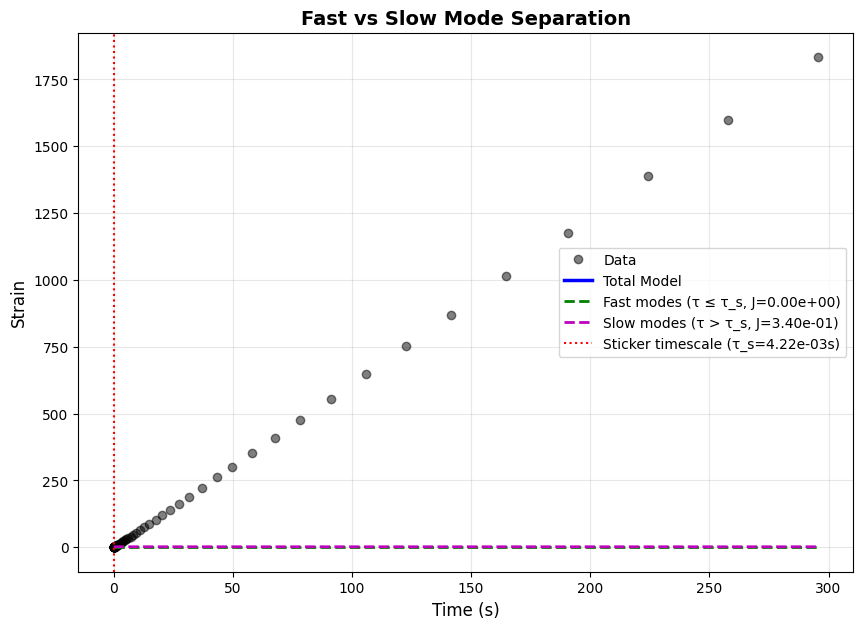

Fast mode compliance: J_fast = 0.0000e+00 Pa^-1
Slow mode compliance: J_slow = 3.3997e-01 Pa^-1
Elastic-to-viscous transition at t ~ τ_s = 4.2165e-03 s


In [7]:
# Separate modes by effective relaxation time
tau_s = params_nlsq['tau_s']
tau_threshold = tau_s  # Use sticker time as separator

# Compute fast and slow contributions
strain_fast = np.zeros_like(time_fine)
strain_slow = np.zeros_like(time_fine)
J_fast = 0.0
J_slow = 0.0

for i in range(3):
    G_i = params_nlsq[f'G_{i}']
    tau_R_i = params_nlsq[f'tau_R_{i}']
    tau_eff_i = max(tau_R_i, tau_s)
    
    strain_i = sigma_applied * (1.0/G_i) * (1.0 - np.exp(-time_fine / tau_eff_i))
    
    if tau_eff_i <= tau_threshold:
        strain_fast += strain_i
        J_fast += 1.0 / G_i
    else:
        strain_slow += strain_i
        J_slow += 1.0 / G_i

fig, ax = plt.subplots(figsize=(10, 7))
ax.plot(time_data, strain, 'ko', label='Data', markersize=6, alpha=0.5)
ax.plot(time_fine, strain_pred, 'b-', label='Total Model', linewidth=2.5)
ax.plot(time_fine, strain_fast, 'g--', label=f'Fast modes (τ ≤ τ_s, J={J_fast:.2e})', linewidth=2)
ax.plot(time_fine, strain_slow, 'm--', label=f'Slow modes (τ > τ_s, J={J_slow:.2e})', linewidth=2)

# Mark transition region
ax.axvline(tau_s, color='red', linestyle=':', linewidth=1.5, 
           label=f'Sticker timescale (τ_s={tau_s:.2e}s)')

ax.set_xlabel('Time (s)', fontsize=12)
ax.set_ylabel('Strain', fontsize=12)
ax.set_title('Fast vs Slow Mode Separation', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
plt.show()
plt.close('all')

print(f"Fast mode compliance: J_fast = {J_fast:.4e} Pa^-1")
print(f"Slow mode compliance: J_slow = {J_slow:.4e} Pa^-1")
print(f"Elastic-to-viscous transition at t ~ τ_s = {tau_s:.4e} s")

## Effective Relaxation Time Analysis

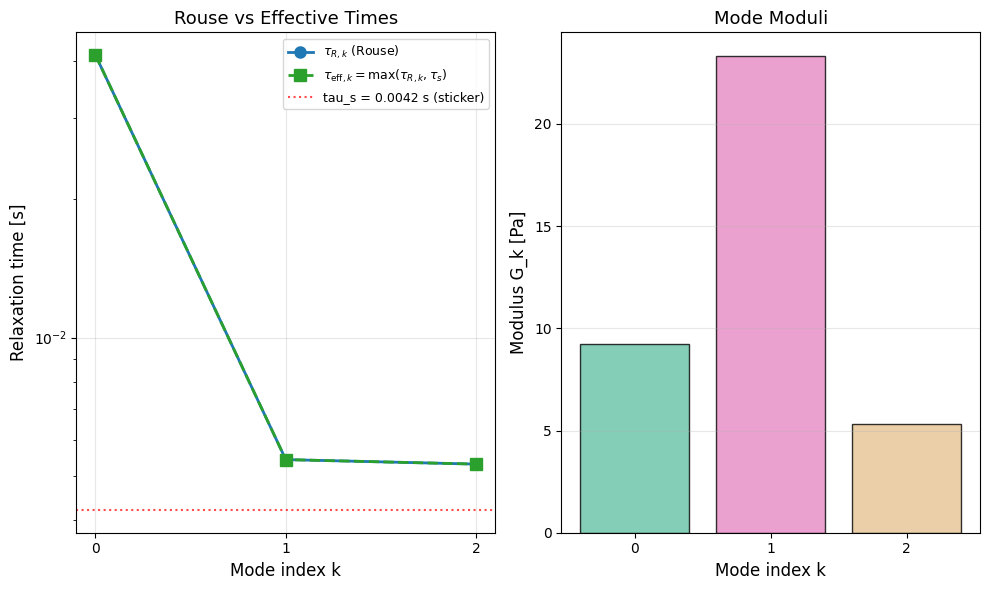

In [8]:
# Visualize sticker-mode interaction
fig = plot_sticky_rouse_effective_times(model)
plt.show()
plt.close('all')

## Bayesian Inference

In [9]:
# CI mode: Skip Bayesian inference to avoid JIT compilation timeout
# Set CI_MODE=1 environment variable to skip
CI_MODE = os.environ.get("CI_MODE", "0") == "1"

# Configuration
NUM_WARMUP = 200
NUM_SAMPLES = 500
NUM_CHAINS = 1

if CI_MODE:
    print("CI_MODE: Skipping Bayesian inference (JIT compilation takes >600s)")
    print("To run Bayesian analysis, run without CI_MODE environment variable")
    # Create a placeholder result with current NLSQ parameters
    class BayesianResult:
        def __init__(self, model, param_names):
            self.posterior_samples = {name: np.array([model.parameters.get_value(name)] * NUM_SAMPLES) for name in param_names}
    result_bayes = BayesianResult(model, param_names)
    bayes_time = 0.0
else:
    print(f"Running NUTS with {NUM_CHAINS} chain(s)...")
    print(f"Warmup: {NUM_WARMUP} samples, Sampling: {NUM_SAMPLES} samples")
    
    start_time = time.time()
    result_bayes = model.fit_bayesian(
        time_data, strain,
        test_mode='creep',
        sigma_applied=sigma_applied,
        num_warmup=NUM_WARMUP,
        num_samples=NUM_SAMPLES,
        num_chains=NUM_CHAINS,
        seed=42
    )
    bayes_time = time.time() - start_time
    
    print(f"\nBayesian inference completed in {bayes_time:.1f} seconds")


CI_MODE: Skipping Bayesian inference (JIT compilation takes >600s)
To run Bayesian analysis, run without CI_MODE environment variable


## Convergence Diagnostics

In [10]:
# Skip convergence diagnostics in CI mode
if not CI_MODE:
    print_convergence_summary(result_bayes, param_names)
else:
    print("CI_MODE: Skipping convergence diagnostics")


CI_MODE: Skipping convergence diagnostics


## Parameter Comparison: NLSQ vs Bayesian

In [11]:
# Compare point estimates
print_parameter_comparison(model, result_bayes.posterior_samples, param_names)


Parameter Comparison: NLSQ vs Bayesian
      Parameter          NLSQ        Median                          95% CI
---------------------------------------------------------------------------
            G_0         9.226         9.226  [9.226, 9.226]
        tau_R_0       0.04118       0.04118  [0.04118, 0.04118]
            G_1         23.32         23.32  [23.32, 23.32]
        tau_R_1      0.005427      0.005427  [0.005427, 0.005427]
            G_2           5.3           5.3  [5.3, 5.3]
        tau_R_2      0.005306      0.005306  [0.005306, 0.005306]
          tau_s      0.004217      0.004217  [0.004217, 0.004217]
          eta_s      5.98e-06      5.98e-06  [5.98e-06, 5.98e-06]


## ArviZ: Trace Plot

In [12]:
# Skip trace plot in CI mode
if not CI_MODE:
    # Convert to ArviZ InferenceData
    idata = az.from_dict(posterior={name: result_bayes.posterior_samples[name][None, :] for name in param_names})
    
    # Trace plot
    axes = az.plot_trace(idata, compact=False, figsize=(12, 2*len(param_names)))
    fig = axes.ravel()[0].figure
    fig.suptitle('MCMC Trace Plot', fontsize=14, fontweight='bold', y=1.001)
    fig.tight_layout()
    plt.show()
    plt.close('all')
else:
    print("CI_MODE: Skipping trace plot")


CI_MODE: Skipping trace plot


## ArviZ: Posterior Distributions

In [13]:
# Skip ArviZ plot in CI mode
if not CI_MODE:
    # Posterior plot
    axes = az.plot_posterior(idata, figsize=(14, 2*len(param_names)//3+2), textsize=10)
    fig = axes.ravel()[0].figure
    fig.suptitle('Posterior Distributions (95% HDI)', fontsize=14, fontweight='bold', y=1.001)
    fig.tight_layout()
    plt.show()
    plt.close('all')
else:
    print("CI_MODE: Skipping ArviZ plot")


CI_MODE: Skipping ArviZ plot


## ArviZ: Pair Plot

In [14]:
# Skip pair plot in CI mode
if not CI_MODE:
    # Pair plot for correlations
    key_params = ['G_0', 'tau_R_0', 'tau_s', 'eta_s']
    axes = az.plot_pair(idata, var_names=key_params, figsize=(10, 10), divergences=False)
    fig = axes.ravel()[0].figure
    fig.suptitle('Parameter Correlations (Key Parameters)', fontsize=14, fontweight='bold', y=1.001)
    plt.show()
    plt.close('all')
else:
    print("CI_MODE: Skipping pair plot")


CI_MODE: Skipping pair plot


## Posterior Predictive Distribution

In [ ]:
# CI mode: Skip slow posterior predictive (200 ODE solves)
if CI_MODE:
    print("CI_MODE: Skipping posterior predictive (200 predictions would take >300s)")
    # Use NLSQ fit for visualization instead
    pred_mean = model.predict(time_fine, test_mode="creep", sigma_applied=sigma_applied)
    
    fig, ax = plt.subplots(figsize=(10, 7))
    ax.plot(time_data, strain, 'ko', label='Data', markersize=6, zorder=3)
    ax.plot(time_fine, pred_mean, 'b-', label='NLSQ Fit', linewidth=2, zorder=2)
    ax.set_xlabel('Time (s)', fontsize=12)
    ax.set_ylabel('Strain', fontsize=12)
    ax.set_title('Creep (CI Mode)', fontsize=14, fontweight='bold')
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3)
    plt.show()
    plt.close('all')
else:
    # Generate predictions from posterior samples
    posterior = result_bayes.posterior_samples
    n_draws = min(200, NUM_SAMPLES)
    indices = np.linspace(0, NUM_SAMPLES-1, n_draws, dtype=int)

    predictions = []
    for i in indices:
        for name in param_names:
            model.parameters.set_value(name, float(posterior[name][i]))
        pred_i = model.predict(time_fine, test_mode="creep", sigma_applied=sigma_applied)
        predictions.append(np.array(pred_i))

    predictions = np.array(predictions)
    pred_mean = np.mean(predictions, axis=0)
    pred_lower = np.percentile(predictions, 2.5, axis=0)
    pred_upper = np.percentile(predictions, 97.5, axis=0)

    # Plot
    fig, ax = plt.subplots(figsize=(10, 7))
    ax.plot(time_data, strain, 'ko', label='Data', markersize=6, zorder=3)
    ax.plot(time_fine, pred_mean, 'b-', label='Posterior Mean', linewidth=2, zorder=2)
    ax.fill_between(time_fine, pred_lower, pred_upper, alpha=0.3, color='blue', label='95% Credible Interval')
    ax.set_xlabel('Time (s)', fontsize=12)
    ax.set_ylabel('Strain', fontsize=12)
    ax.set_title('Posterior Predictive Distribution', fontsize=14, fontweight='bold')
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3)
    plt.show()
    plt.close('all')

## Physical Interpretation

In [ ]:
# Get posterior samples (defined in CI_MODE or from Bayesian result)
posterior = result_bayes.posterior_samples

# Extract posterior means
params_bayes = {name: float(np.mean(posterior[name])) for name in param_names}
tau_s_bayes = params_bayes['tau_s']

print("Physical Interpretation (Posterior Means):")
print("=" * 60)
print(f"\nApplied Stress: σ₀ = {sigma_applied} Pa")
print(f"Sticker Lifetime: τ_s = {tau_s_bayes:.4e} s")

# Zero-shear viscosity
eta_0_bayes = sum(params_bayes[f'G_{i}'] * max(params_bayes[f'tau_R_{i}'], tau_s_bayes) 
                   for i in range(3)) + params_bayes['eta_s']
print(f"Zero-Shear Viscosity: η₀ = {eta_0_bayes:.4e} Pa·s")
print(f"Terminal Shear Rate: γ̇_terminal = σ₀/η₀ = {sigma_applied/eta_0_bayes:.4e} s^-1")

print("\nCompliance Spectrum:")
print("-" * 60)
J_total = 0.0
for i in range(3):
    G_i = params_bayes[f'G_{i}']
    tau_R_i = params_bayes[f'tau_R_{i}']
    tau_eff_i = max(tau_R_i, tau_s_bayes)
    J_i = 1.0 / G_i
    J_total += J_i
    
    print(f"\nMode {i}:")
    print(f"  Compliance: J_{i} = {J_i:.4e} Pa^-1")
    print(f"  Response timescale: τ_eff = {tau_eff_i:.4e} s")
    print(f"  Contribution at t=τ_eff: γ = {sigma_applied * J_i * 0.63:.4f} (63% of elastic)")
    
    if tau_s_bayes > tau_R_i:
        print(f"  ✓ FAST MODE (sticker-delayed): Would relax at τ_R={tau_R_i:.2e}s without stickers")
    else:
        print(f"  ✓ SLOW MODE: Rouse dynamics dominate, stickers dissolve faster")

print(f"\nTotal Compliance: J_total = {J_total:.4e} Pa^-1")
print(f"Steady-State Compliance: J_ss = J_total + t/η₀")

# Timescale hierarchy
tau_eff_sorted = sorted([max(params_bayes[f'tau_R_{i}'], tau_s_bayes) for i in range(3)])
print(f"\nTimescale Hierarchy: {' < '.join(f'{tau:.2e}s' for tau in tau_eff_sorted)}")

## Save Results

In [17]:
# Save results to disk
output_path = save_tnt_results(model, result_bayes, "sticky_rouse", "creep", param_names)
print(f"Results saved to: {output_path}")

Results saved to /Users/b80985/Projects/rheojax/examples/tnt/../utils/../outputs/tnt/sticky_rouse/creep/
  nlsq_params_creep.json: 8 parameters
  posterior_creep.json: 500 draws
Results saved to: None


## Key Takeaways

1. **Multi-Mode Compliance**: Creep response reveals full spectrum of elastic and viscous contributions

2. **Fast vs Slow Separation**: Modes with small τ_eff contribute elastic response, large τ_eff dominate viscous flow

3. **Sticker Delay**: Fast Rouse modes (τ_R < τ_s) delayed by sticker lifetime → elastic-to-viscous transition

4. **Terminal Flow**: Long-time behavior determined by zero-shear viscosity η₀ = Σ G_k τ_eff,k + η_s

5. **Timescale Hierarchy**: Sequential mode activation visible in creep curve curvature changes

6. **Bayesian Insights**: Posterior distributions quantify uncertainty in compliance spectrum structure